## Training XGBoost

### 1. Data Preparation and cleaning

In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [57]:
df = pd.read_csv("fitness_class_2212.csv")

In [58]:
df.weight = df.weight.fillna(df.weight.median()) #For ExtraTreesClassifier, there is a need to handle missing values, not for XGBoost
df.drop('booking_id', axis=1, inplace=True)  # drop the booking_id column as it's irrelevant to the analysis
df.days_before = df.days_before.str.replace(r' days$', '', regex=True) # Remove ' days'
df.days_before = pd.to_numeric(df.days_before, errors='coerce').astype(int) # Convert the cleaned values to integers

df.day_of_week = df.day_of_week.replace({'Wednesday': 'Wed', 'Monday': 'Mon'})  # Replace 'Wednesday' with 'Wed'
df.day_of_week = df.day_of_week.str.replace(r'Fri\.$', 'Fri', regex=True)  # Use raw string to remove period from 'Fri.'
df.category = df.category.replace('-', 'Unknown')  # Replace with "Unknown" instead of NaN to prevent information loss

### 2. Splitting the data, extracting target variables, dropping target column and transforming features

In [59]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['attended'].values
y_val = df_val['attended'].values
y_test = df_test['attended'].values

del df_train['attended']
del df_val['attended']
del df_test['attended']

### Bringing in the Logisitic regression model from the original notebook for easy model comparison

In [60]:
numerical = ['months_as_member', 'weight', 'days_before']
categorical = ['day_of_week', 'time', 'category']

In [61]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [62]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [63]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
attendance_decision = (y_pred >= 0.5)
(y_val == attendance_decision).mean()

np.float64(0.78)

In [124]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [125]:
dv, model = train(df_train, y_train, C=0.001)

In [128]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [136]:
dv, model = train(df_full_train, df_full_train.attended.values, C=1)
y_pred = predict(df_val, dv, model)

val_auc = roc_auc_score(y_val, y_pred)
print("Test AUC with Interaction Features:", val_auc)

Test AUC with Interaction Features: 0.8520634920634922


In [135]:
dv, model = train(df_full_train, df_full_train.attended.values, C=0.01)
y_pred = predict(df_test, dv, model)

test_auc = roc_auc_score(y_test, y_pred)
print("Test AUC with Interaction Features:", test_auc)

Test AUC with Interaction Features: 0.7852655912357405


### 4a. Training, tuning and evaluating an XGBoost model
- XG Boost: XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. https://www.nvidia.com/en-us/glossary/xgboost/

In [69]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [70]:
import xgboost as xgb

In [77]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [78]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 10,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 1,
}

In [79]:
watchlist = [(dtrain, "train"), (dval, "val")]

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=10,
)

[0]	train-auc:0.88321	val-auc:0.76874
[10]	train-auc:0.94066	val-auc:0.82056
[20]	train-auc:0.95743	val-auc:0.81038


In [80]:
y_pred = model.predict(dtest)

test_auc = roc_auc_score(y_test, y_pred)
print("XGBoost Test AUC:", test_auc)

XGBoost Test AUC: 0.747449620583949


#### 4b. Performing cross-validation to ensure robustness

In [81]:
cv_results = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=5,
    metrics="auc",
    early_stopping_rounds=10,
    seed=1
)
print("Cross-Validation AUC:", cv_results["test-auc-mean"].max())

Cross-Validation AUC: 0.7947451718118599


In [82]:
print("Cross-Validation AUC Std Dev:", cv_results["test-auc-std"].iloc[-1])

Cross-Validation AUC Std Dev: 0.028625462297835913


##### The Cross-Validation AUC Standard Deviation of 0.0245 is quite low, indicating that your model's performance is stable across the folds. This consistency is a good sign of generalizability and suggests that your model is robust.

#### 4c. Trying a grid search for key hyperparameters using cross-validation

In [83]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "max_depth": [5, 7, 10],
    "eta": [0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

best_params = None
best_cv_auc = 0

for params in ParameterGrid(param_grid):
    xgb_params.update(params)
    
    cv_results = xgb.cv(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        metrics="auc",
        early_stopping_rounds=10,
        seed=1,
        verbose_eval=False,
    )
    
    mean_auc = cv_results["test-auc-mean"].max()
    if mean_auc > best_cv_auc:
        best_cv_auc = mean_auc
        best_params = params

print("Best Params:", best_params)
print("Best Cross-Validation AUC:", best_cv_auc)

Best Params: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7}
Best Cross-Validation AUC: 0.8150186623386606


##### Explanation:
- `colsample_bytree = 0.8`: This means the model uses 80% of the features for each tree, balancing feature diversity and predictive power.
- `eta = 0.1`: A learning rate of 0.1 ensures gradual updates, preventing overshooting during optimization.
- `max_depth = 5`: A shallower depth reduces overfitting, capturing essential patterns without over-complicating the model.
- `subsample = 0.7`: Sampling 70% of the training data for each tree improves robustness and reduces overfitting.
- `Cross-Validation AUC of 0.8150` is a significant improvement over the previous Cross-Validation AUC of 0.7947, suggesting that the new parameters generalize better across folds.

#### 4d. Training the final XGBoost Model

In [96]:
# Combining training and validation sets
dtrain_full = xgb.DMatrix(
    data=np.vstack([X_train, X_val]),
    label=np.hstack([y_train, y_val])
)

In [97]:
# Updating parameters with the best ones
final_xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 5,
    "eta": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "random_state": 1,
}

In [98]:
# Train on the combined dataset
final_model = xgb.train(
    params=final_xgb_params,
    dtrain=dtrain_full,
    num_boost_round=100,
    evals=[(dtrain_full, "train")],
    early_stopping_rounds=10,
    verbose_eval=10,
)

[0]	train-auc:0.84246
[10]	train-auc:0.88351
[20]	train-auc:0.89398
[30]	train-auc:0.90360
[40]	train-auc:0.91430
[50]	train-auc:0.92019
[60]	train-auc:0.92578
[70]	train-auc:0.93232
[80]	train-auc:0.93804
[90]	train-auc:0.94355
[99]	train-auc:0.94933


In [99]:
# Test predictions
y_pred = final_model.predict(dtest)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_pred)
print("Final XGBoost Test AUC:", test_auc)

Final XGBoost Test AUC: 0.7609930147243581


#### The Final XGBoost Test AUC of 0.7610 is a solid improvement over the previous Test AUC (0.7474). This indicates that tuning the hyperparameters significantly enhanced the model's ability to generalize to unseen data.

#### Feature Importance Analysis
- The gain (importance) scores in XGBoost quantify how much each feature contributes to improving the model's predictive performance across all trees and splits in the ensemble.

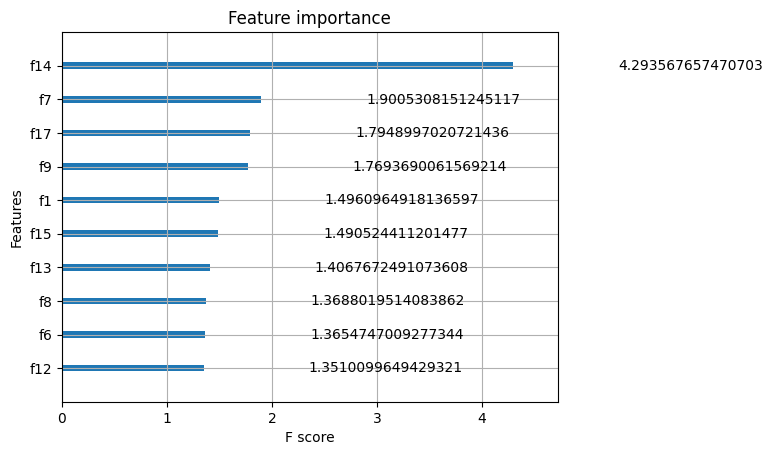

In [100]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model, max_num_features=10, importance_type="gain")
plt.show()

In [101]:
feature_names = dv.get_feature_names_out()
feature_names

array(['category=Aqua', 'category=Cycling', 'category=HIIT',
       'category=Strength', 'category=Unknown', 'category=Yoga',
       'day_of_week=Fri', 'day_of_week=Mon', 'day_of_week=Sat',
       'day_of_week=Sun', 'day_of_week=Thu', 'day_of_week=Tue',
       'day_of_week=Wed', 'days_before', 'months_as_member', 'time=AM',
       'time=PM', 'weight'], dtype=object)

In [111]:
# Get feature importance by gain
feature_importance = final_model.get_score(importance_type="gain")

# Map feature indices (f0, f1, ...) to actual feature names
feature_map = {f"f{i}": name for i, name in enumerate(dv.get_feature_names_out())}  # For DictVectorizer

# Replace feature indices with actual names
feature_importance_named = {feature_map[k]: v for k, v in feature_importance.items()}

# Convert to sorted list of tuples
sorted_importance = sorted(feature_importance_named.items(), key=lambda x: x[1], reverse=True)

# Split names and scores for plotting
features = [x[0] for x in sorted_importance]
scores = [x[1] for x in sorted_importance]

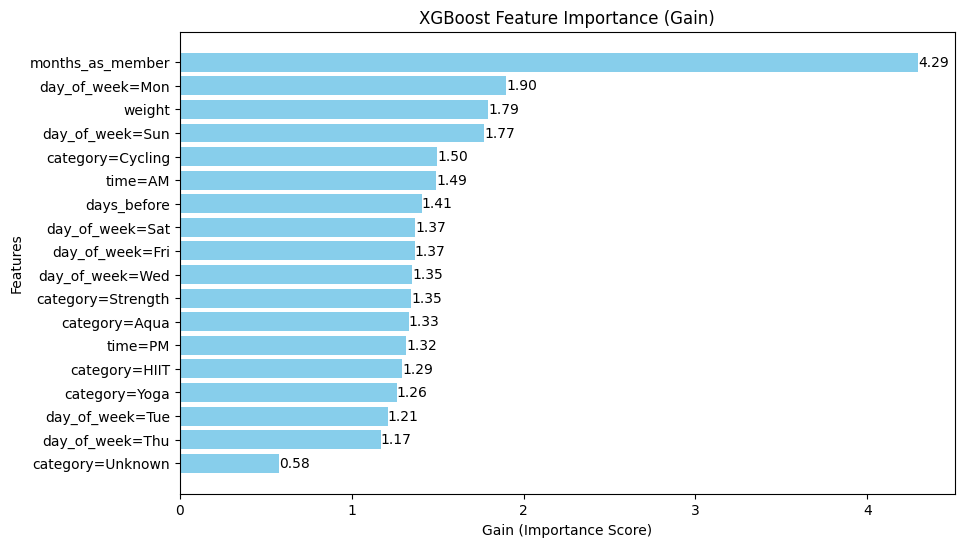

In [112]:
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='skyblue')
plt.xlabel("Gain (Importance Score)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Gain)")
plt.gca().invert_yaxis()  # Show most important feature at the top

# Add scores as text on the bars
for i, score in enumerate(scores):
    plt.text(score, i, f"{score:.2f}", va='center')

plt.show()

Summary:
- The scores are relative. For example, `months_as_member` (4.29) is about 2.4x more important than `weight` (1.79).
- `months_as_member` is the dominant feature.
- Categorical features (e.g., day_of_week, category) also play a significant role, but their contributions are spread across multiple categories.
- Some features (e.g., category=Unknown) have minimal importance and may not be worth including in the model.

### 5. Feature Interaction Model
- Identify key features for interaction based on the importance scores
- Create interaction features (numerical-numerical features, categorical-categorical interactions, numerical-categorical interactions
- Evaluate impact

In [157]:
# Interaction: Multiply and divide numerical features
df_full_train['interaction_mm_weight'] = df_full_train['months_as_member'] * df_full_train['weight']
df_full_train['interaction_mm_days'] = df_full_train['months_as_member'] / (df_full_train['days_before'] + 1e-9)  # Avoid division by zero

In [158]:
df_full_train['interaction_day_time'] = df_full_train['day_of_week'] + "_" + df_full_train['time']

In [159]:
# Interaction: Multiply numerical features by binary indicators
df_full_train['interaction_mm_mon'] = df_full_train['months_as_member'] * (df_full_train['day_of_week'] == 'Mon').astype(int)
df_full_train['interaction_weight_cycling'] = df_full_train['weight'] * (df_full_train['category'] == 'Cycling').astype(int)

In [160]:
# Adding interactions to training, validation, and test sets
for df in [X_train, X_val, X_test]:
    df['interaction_mm_weight'] = df['months_as_member'] * df['weight']
    df['interaction_mm_days'] = df['months_as_member'] / (df['days_before'] + 1e-9)

    # Use one-hot encoded day_of_week columns
    df['interaction_day_time'] = (
        df['day_of_week=Mon'] * (df['time=AM'] == 1).astype(int) +
        df['day_of_week=Fri'] * (df['time=PM'] == 1).astype(int)
    )
    
    df['interaction_mm_mon'] = df['months_as_member'] * df['day_of_week=Mon']
    df['interaction_weight_cycling'] = df['weight'] * df['category=Cycling']

In [161]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [162]:
y_pred = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred)
print("Validation AUC with Interaction Features:", val_auc)

Validation AUC with Interaction Features: 0.8355067155067156


In [163]:
y_pred = model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)
print("Test AUC with Interaction Features:", test_auc)

Test AUC with Interaction Features: 0.7781295542489572


### 6. Selecting the final model
- Choosing between logistic regression, XGBoost and Feature Interaction Model